# HW2 

@author Hamidreza Abooei

@id 402617509


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import KFold


In [2]:
data1 = pd.read_csv("data1.csv")

In [3]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1000 non-null   int64  
 1   x1          1000 non-null   float64
 2   x2          1000 non-null   float64
 3   y           1000 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 31.4 KB


remove unwanted column

In [4]:
data1 = data1.drop(['Unnamed: 0'],axis=1)

In [5]:
data1.isna().sum()

x1    0
x2    0
y     0
dtype: int64

remove outlier

In [6]:
numeric_col = data1.keys()

for x in numeric_col:
    q75,q25 = np.percentile(data1.loc[:,x],[75,25])  # a box plot of the quartile range and min/max values method
    IQR = q75-q25
    max_data = q75+(1.5*IQR)
    min_data = q25-(1.5*IQR)
 
    data1.loc[data1[x] < min_data,x] = np.nan   #filling the outliers values with 'nan'
    data1.loc[data1[x] > max_data,x] = np.nan   #filling the outliers values with 'nan'


data1.isna().sum()

x1    8
x2    0
y     0
dtype: int64

In [26]:
data1 = data1.dropna()
data1.isna().sum()

x1    0
x2    0
y     0
dtype: int64

In [9]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 992 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      992 non-null    float64
 1   x2      992 non-null    float64
 2   y       992 non-null    float64
dtypes: float64(3)
memory usage: 31.0 KB


In [10]:
X = data1.drop(['y'],axis = 1)
Y = data1['y']

Selected k is  9


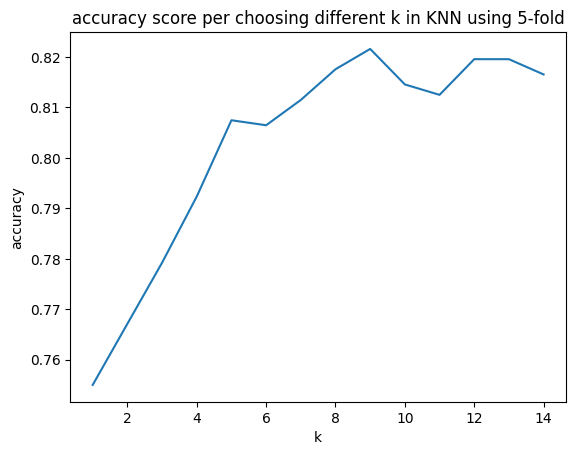

In [13]:
n_splits = 5
max_k = 15
accuracy_matrix = np.zeros((n_splits, max_k-1))

kf = KFold(n_splits=n_splits)
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index],Y.iloc[train_index],Y.iloc[test_index]

    for k in range(1,max_k):
        # initialize K nearest neighborhood
        neigh = KNeighborsClassifier(n_neighbors=k)
        neigh.fit(X_train,Y_train)
        y_pred = neigh.predict(X_test)  
        acc = accuracy_score(Y_test,y_pred)
        accuracy_matrix[i,k-1] = acc
        # print( f'k={k}',"\tis ",acc)
acc_final = np.mean(accuracy_matrix,axis=0)

selected_k = np.argmax(acc_final)+1
print("Selected k is ",selected_k)
plt.figure()
plt.plot(range(1,15),acc_final)
plt.ylabel("accuracy")
plt.xlabel("k")
plt.title(f"accuracy score per choosing different k in KNN using {n_splits}-fold")
plt.show()

Confusion Matrix

In [14]:
neigh = KNeighborsClassifier(n_neighbors=selected_k)
# Using the data of one of the kfolds (last one) to generate and show confusion matrix
neigh.fit(X_train,Y_train)
y_pred = neigh.predict(X_test)
acc = accuracy_score(Y_test,y_pred)
y_score = neigh.predict_proba(X_test)

In [15]:
print(y_score.shape)

(198, 5)


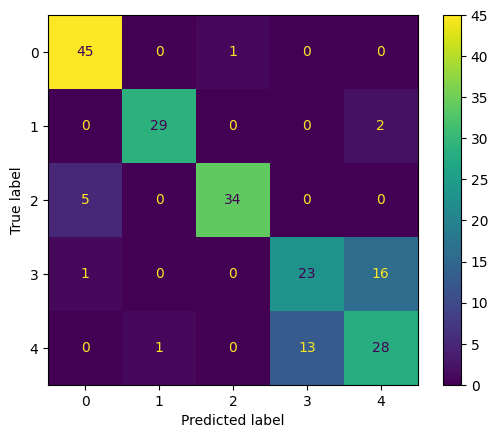

In [16]:
confmat = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confmat)
disp.plot()

In [17]:

label_binarizer = LabelBinarizer().fit(Y_train)
y_onehot_test = label_binarizer.transform(Y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(198, 5)

In [18]:
label_binarizer.transform([2,3])

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0]])

In [19]:
class_of_interest = 0
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

0

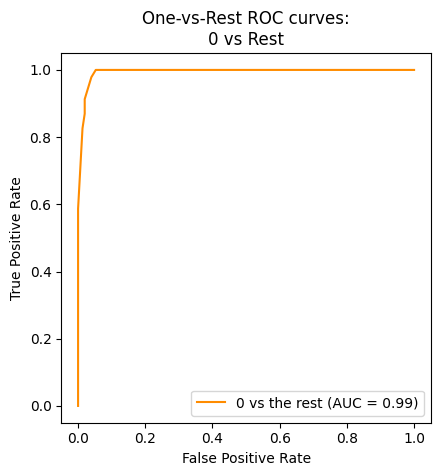

In [20]:
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\n0 vs Rest")
plt.legend()
plt.show()

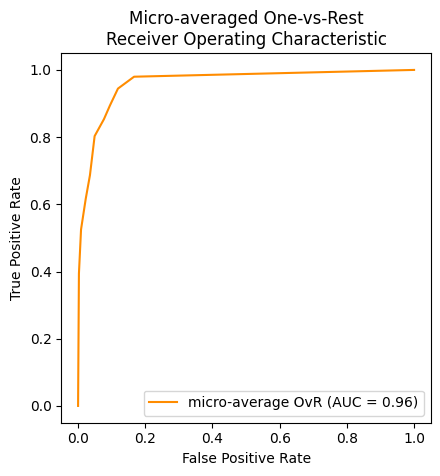

In [21]:
RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange"
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

In [22]:
micro_roc_auc_ovr = roc_auc_score(
    Y_test,
    y_score,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")


Macro-averaged One-vs-Rest ROC AUC score:
0.95


In [23]:
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.96


In [24]:
n_classes = 5
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.95


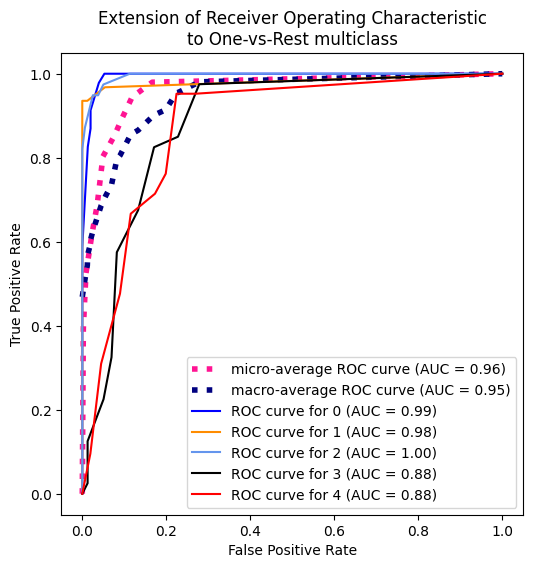

In [25]:
from itertools import cycle
fig, ax = plt.subplots(figsize=(6, 6))
target_names = [0,1,2,3,4]
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["blue", "darkorange", "cornflowerblue","black","red"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
        # plot_chance_level=(class_id == 2),
    )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()